In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import *
from keras.datasets import mnist
from keras.optimizers import Adam
import os
import math

In [ ]:
(XT,_),(_,_) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
XT.shape

(60000, 28, 28)

In [ ]:
XT = XT.reshape((-1,28,28,1))
print(XT.shape)

(60000, 28, 28, 1)


In [ ]:
#Normalizing the data in range [-1,1]
XT = (XT.astype('float') - 127.5)/127.5
print(np.unique(XT))

[-1.         -0.99215686 -0.98431373 -0.97647059 -0.96862745 -0.96078431
 -0.95294118 -0.94509804 -0.9372549  -0.92941176 -0.92156863 -0.91372549
 -0.90588235 -0.89803922 -0.89019608 -0.88235294 -0.8745098  -0.86666667
 -0.85882353 -0.85098039 -0.84313725 -0.83529412 -0.82745098 -0.81960784
 -0.81176471 -0.80392157 -0.79607843 -0.78823529 -0.78039216 -0.77254902
 -0.76470588 -0.75686275 -0.74901961 -0.74117647 -0.73333333 -0.7254902
 -0.71764706 -0.70980392 -0.70196078 -0.69411765 -0.68627451 -0.67843137
 -0.67058824 -0.6627451  -0.65490196 -0.64705882 -0.63921569 -0.63137255
 -0.62352941 -0.61568627 -0.60784314 -0.6        -0.59215686 -0.58431373
 -0.57647059 -0.56862745 -0.56078431 -0.55294118 -0.54509804 -0.5372549
 -0.52941176 -0.52156863 -0.51372549 -0.50588235 -0.49803922 -0.49019608
 -0.48235294 -0.4745098  -0.46666667 -0.45882353 -0.45098039 -0.44313725
 -0.43529412 -0.42745098 -0.41960784 -0.41176471 -0.40392157 -0.39607843
 -0.38823529 -0.38039216 -0.37254902 -0.36470588 -0.3

In [ ]:
batch_size = 256
epochs = 50
n_batches = math.ceil(XT.shape[0]/batch_size)
half_batch = 128
noise_dim = 100 # this will be used to generate 784 dimension vector
adam = Adam(lr=2e-4,beta_1=0.5)

In [ ]:
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(noise_dim,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(UpSampling2D())
generator.add(Conv2D(1,kernel_size=(5,5),padding='same',activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU())

discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [ ]:
!mkdir images
!mkdir models
!ls

images	models	sample_data


In [ ]:
#GAN
discriminator.trainable = False
gan_input = Input(shape=(noise_dim,))
generated_image = generator(gan_input)

gan_output = discriminator(generated_image)

#using the keras functional API to combine the two models
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [ ]:
def save_images(epoch,samples=100):
    noise = np.random.normal(0,1,(samples,noise_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape((-1,28,28))
    plt.figure(figsize=(10,10))

    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_images[i],cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

Epoch 1 Discriminator Loss 0.6600 Generator Loss 0.9498
Epoch 2 Discriminator Loss 0.6587 Generator Loss 0.9547
Epoch 3 Discriminator Loss 0.6580 Generator Loss 0.9594
Epoch 4 Discriminator Loss 0.6577 Generator Loss 0.9666
Epoch 5 Discriminator Loss 0.6560 Generator Loss 0.9681


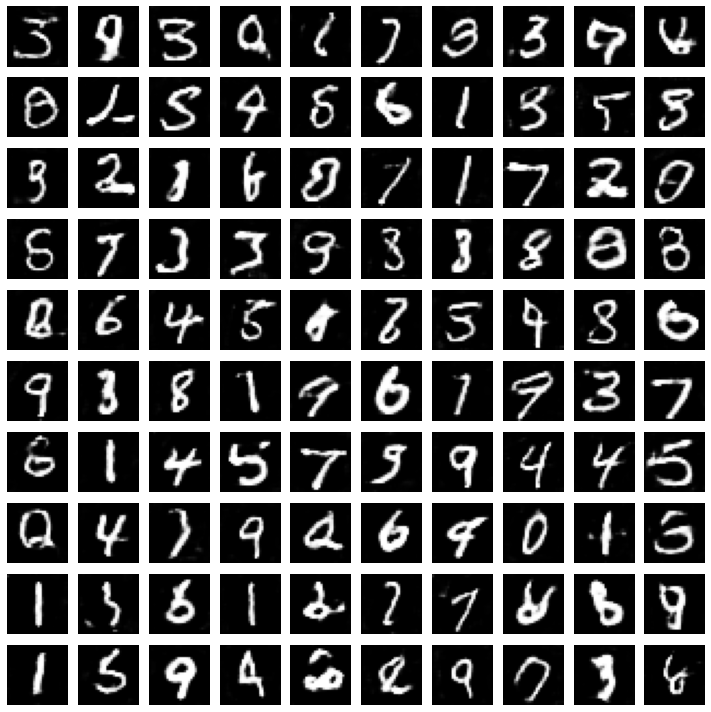

Epoch 6 Discriminator Loss 0.6549 Generator Loss 0.9744
Epoch 7 Discriminator Loss 0.6535 Generator Loss 0.9793
Epoch 8 Discriminator Loss 0.6527 Generator Loss 0.9852
Epoch 9 Discriminator Loss 0.6506 Generator Loss 0.9902
Epoch 10 Discriminator Loss 0.6497 Generator Loss 0.9956


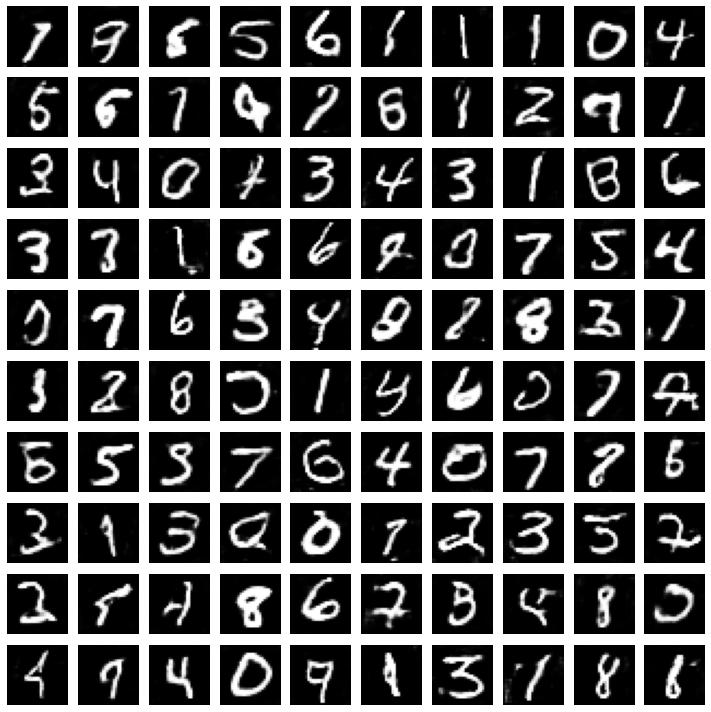

Epoch 11 Discriminator Loss 0.6477 Generator Loss 1.0032
Epoch 12 Discriminator Loss 0.6473 Generator Loss 1.0080
Epoch 13 Discriminator Loss 0.6471 Generator Loss 1.0144
Epoch 14 Discriminator Loss 0.6443 Generator Loss 1.0180
Epoch 15 Discriminator Loss 0.6453 Generator Loss 1.0271


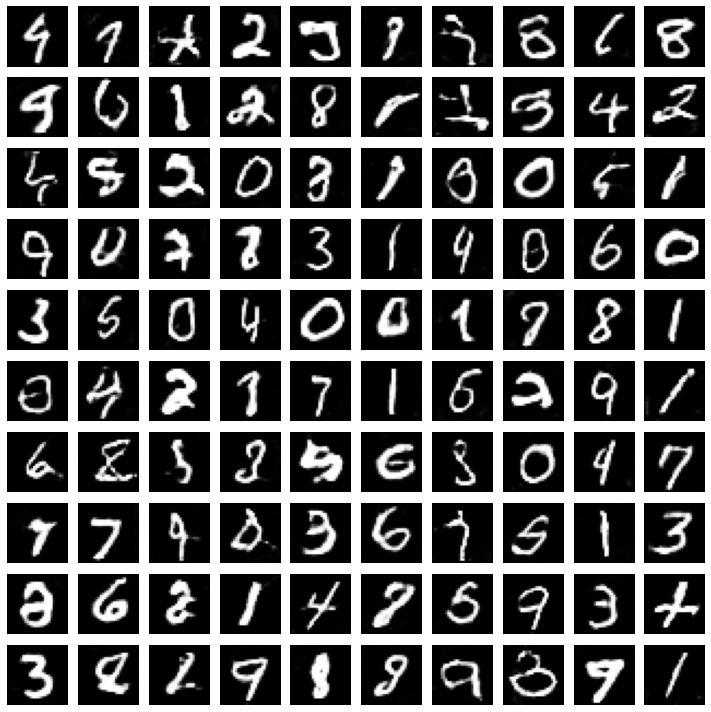

Epoch 16 Discriminator Loss 0.6421 Generator Loss 1.0338
Epoch 17 Discriminator Loss 0.6411 Generator Loss 1.0377
Epoch 18 Discriminator Loss 0.6405 Generator Loss 1.0459
Epoch 19 Discriminator Loss 0.6388 Generator Loss 1.0523
Epoch 20 Discriminator Loss 0.6388 Generator Loss 1.0577


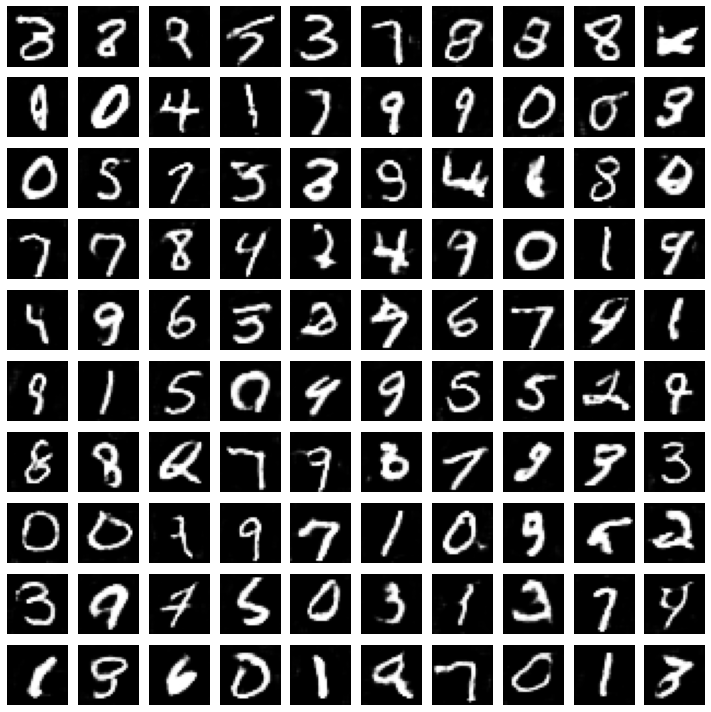

Epoch 21 Discriminator Loss 0.6377 Generator Loss 1.0612
Epoch 22 Discriminator Loss 0.6353 Generator Loss 1.0635
Epoch 23 Discriminator Loss 0.6348 Generator Loss 1.0753
Epoch 24 Discriminator Loss 0.6328 Generator Loss 1.0814
Epoch 25 Discriminator Loss 0.6327 Generator Loss 1.0829


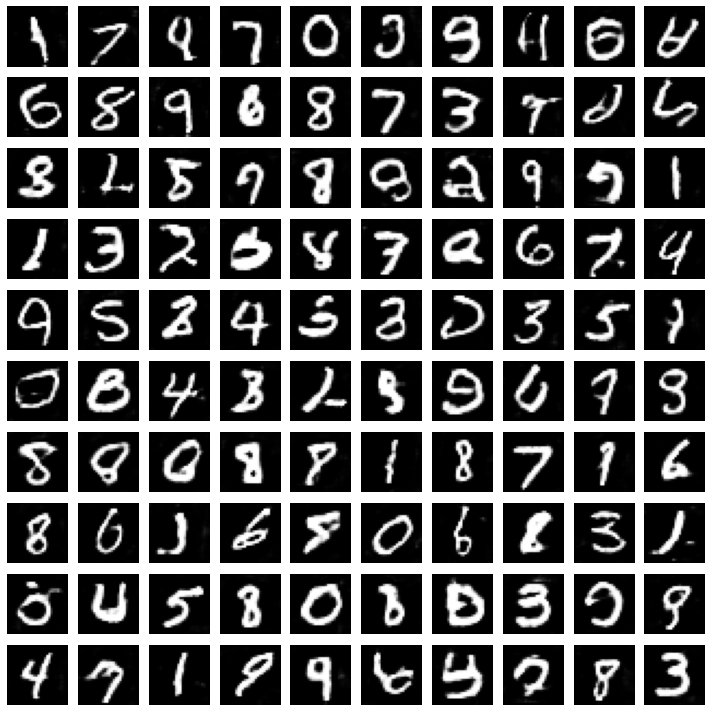

Epoch 26 Discriminator Loss 0.6314 Generator Loss 1.0913
Epoch 27 Discriminator Loss 0.6311 Generator Loss 1.0972
Epoch 28 Discriminator Loss 0.6283 Generator Loss 1.1067
Epoch 29 Discriminator Loss 0.6293 Generator Loss 1.1065
Epoch 30 Discriminator Loss 0.6271 Generator Loss 1.1125


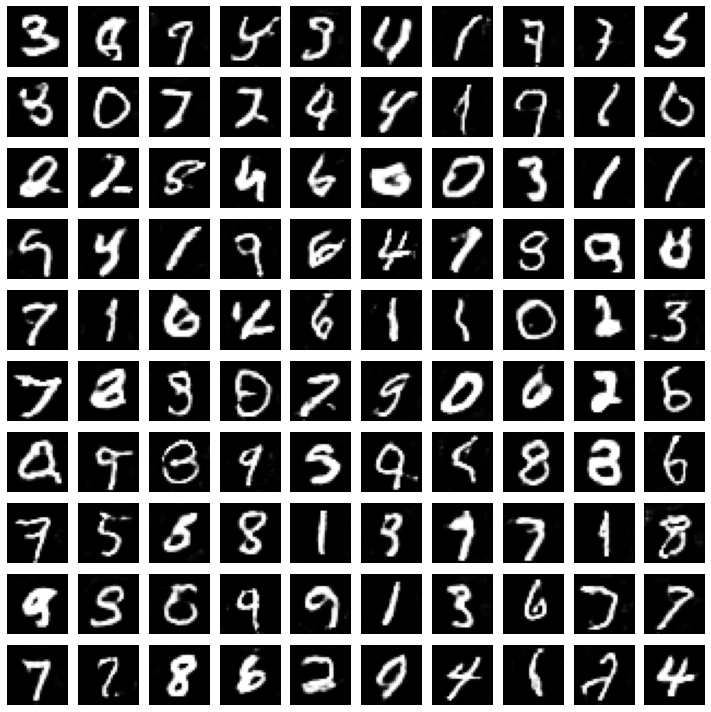

Epoch 31 Discriminator Loss 0.6266 Generator Loss 1.1177
Epoch 32 Discriminator Loss 0.6240 Generator Loss 1.1306
Epoch 33 Discriminator Loss 0.6250 Generator Loss 1.1335
Epoch 34 Discriminator Loss 0.6221 Generator Loss 1.1372
Epoch 35 Discriminator Loss 0.6219 Generator Loss 1.1548


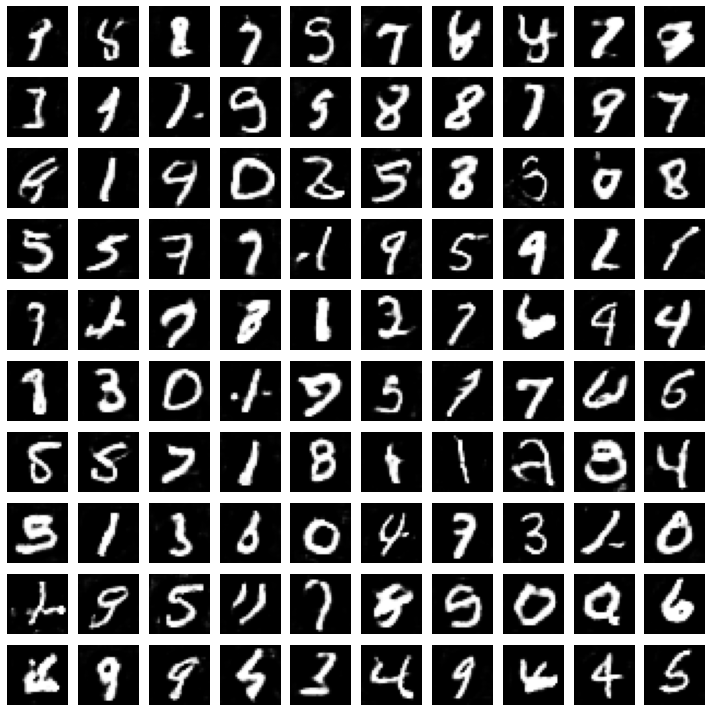

Epoch 36 Discriminator Loss 0.6197 Generator Loss 1.1523
Epoch 37 Discriminator Loss 0.6199 Generator Loss 1.1619
Epoch 38 Discriminator Loss 0.6177 Generator Loss 1.1641
Epoch 39 Discriminator Loss 0.6182 Generator Loss 1.1753
Epoch 40 Discriminator Loss 0.6170 Generator Loss 1.1731


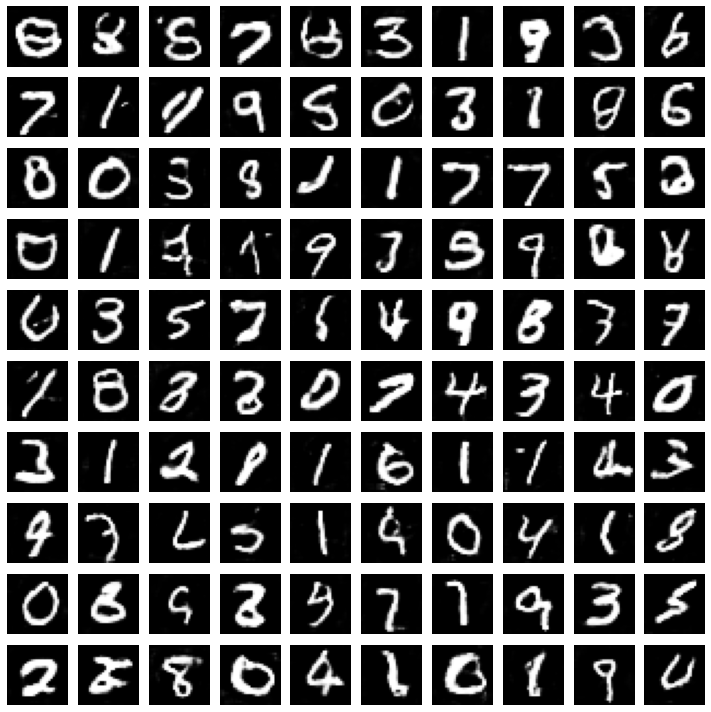

Epoch 41 Discriminator Loss 0.6158 Generator Loss 1.1862
Epoch 42 Discriminator Loss 0.6147 Generator Loss 1.1845
Epoch 43 Discriminator Loss 0.6139 Generator Loss 1.1954
Epoch 44 Discriminator Loss 0.6141 Generator Loss 1.1994
Epoch 45 Discriminator Loss 0.6123 Generator Loss 1.2094


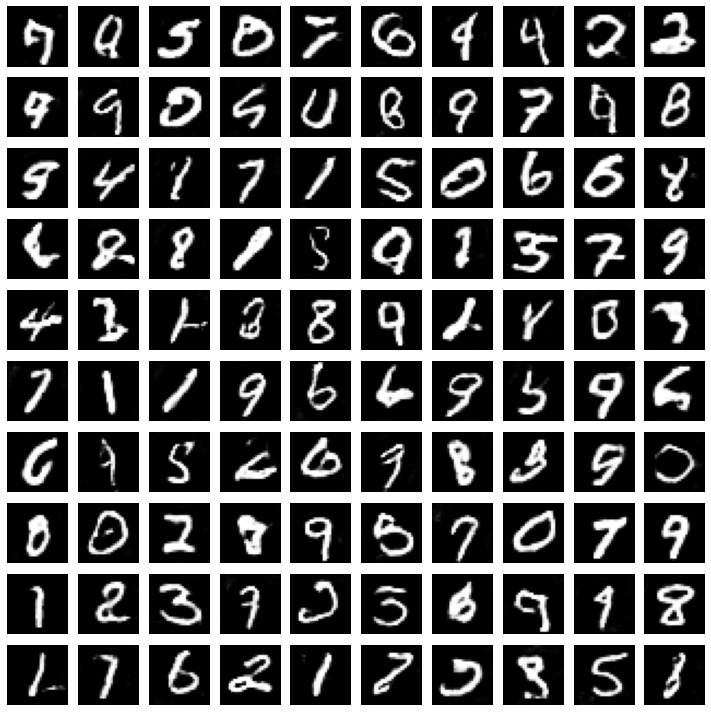

Epoch 46 Discriminator Loss 0.6102 Generator Loss 1.2076
Epoch 47 Discriminator Loss 0.6114 Generator Loss 1.2134
Epoch 48 Discriminator Loss 0.6092 Generator Loss 1.2190
Epoch 49 Discriminator Loss 0.6093 Generator Loss 1.2280
Epoch 50 Discriminator Loss 0.6071 Generator Loss 1.2324


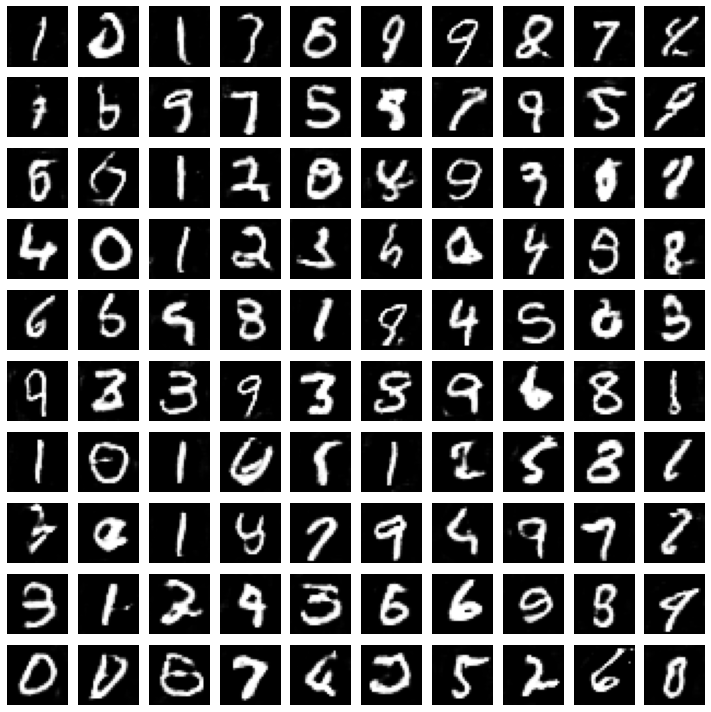

In [ ]:
dloss = []
gloss = []
for epoch in range(epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0

    #Mini Batch Gradient Descend
    for batch in range(n_batches):
        #training the discriminator with 50% real data and 50% fake data
        idx = np.random.randint(0,XT.shape[0],half_batch)
        real_imgs = XT[idx]

        noise = np.random.normal(0,1,size=(half_batch,noise_dim))
        fake_imgs = generator.predict(noise)

        real_y = np.ones((half_batch,1))*0.9 #one sided label smoothing for discriminator
        fake_y = np.zeros((half_batch,1))

        real_loss_d,fake_loss_d = discriminator.train_on_batch(real_imgs,real_y),discriminator.train_on_batch(fake_imgs,fake_y)
        loss_d = (real_loss_d + fake_loss_d)/2.0

        epoch_d_loss += loss_d
        dloss.append(loss_d)
        #training the generator considering frozen discriminator
        noise = np.random.normal(0,1,(batch_size,noise_dim))
        labels = np.ones((batch_size,1))

        loss_g = model.train_on_batch(noise,labels)
        epoch_g_loss += loss_g
        
    dloss.append(epoch_d_loss/n_batches)
    gloss.append(epoch_g_loss/n_batches)
        
    print('Epoch %d Discriminator Loss %.4f Generator Loss %.4f' %((epoch+1),epoch_d_loss/n_batches,epoch_g_loss/n_batches))
    if (epoch+1)%5 == 0:
        generator.save('models/gen_generator{0}.h5'.format(epoch+1))
        save_images(epoch)

In [ ]:
!zip -r /content/images.zip /content/images

updating: content/images/ (stored 0%)
updating: content/images/gan_output_epoch_30.png (deflated 7%)
updating: content/images/gan_output_epoch_10.png (deflated 7%)
updating: content/images/gan_output_epoch_15.png (deflated 7%)
updating: content/images/gan_output_epoch_50.png (deflated 7%)
updating: content/images/gan_output_epoch_45.png (deflated 7%)
updating: content/images/gan_output_epoch_20.png (deflated 7%)
updating: content/images/gan_output_epoch_25.png (deflated 7%)
updating: content/images/gan_output_epoch_35.png (deflated 7%)
updating: content/images/gan_output_epoch_40.png (deflated 7%)
updating: content/images/gan_output_epoch_5.png (deflated 7%)


In [ ]:
from google.colab import files
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>